# Feature Extraction

1. Ridge Patterns: Fingerprints classified into Arch, Loop, and Whorl.
2. Patch Analysis: Fingerprints divided into patches; local ridge orientation analyzed.
3. Statistical Features: Counts of each pattern converted into a distribution   vector.
4. Feature Fusion: Combined ridge distribution with CNN-extracted deep features.
5. Impact: Improved robustness and classification accuracy, especially for rare blood groups.


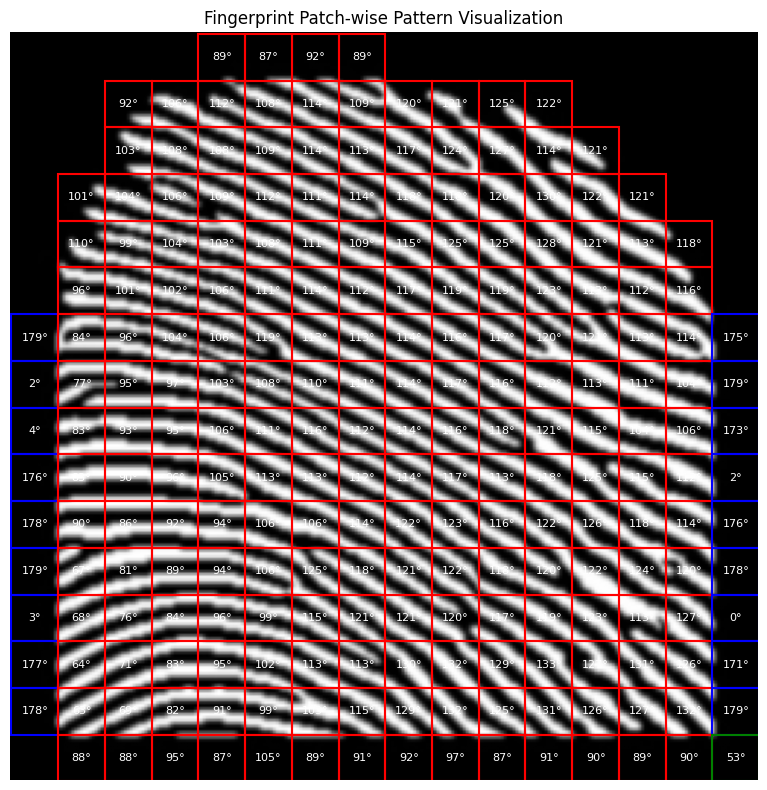


📊 Pattern Distribution:
Arch: 206 patches (91.6%)
Loop: 1 patches (0.4%)
Whorl: 18 patches (8.0%)
Other: 0 patches (0.0%)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Configuration
IMAGE_PATH = "/mnt/data/ec646bbc-9e6a-4f20-9ac8-b9fccf524584.png"  # uploaded path
PATCH_SIZE = 16
IMG_SIZE = 256
WHITE_PX_THR = 0.15

COLOR_MAP = {
    'Arch': 'red',
    'Loop': 'green',
    'Whorl': 'blue',
    'Other': 'yellow'
}

def compute_orientation(block):
    gx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    angle = 0.5 * np.arctan2(2 * np.sum(gx * gy), np.sum(gx**2 - gy**2))
    return np.degrees(angle) % 180

def classify_pattern(angle_deg):
    a = angle_deg % 180.0  # Normalize to [0, 180)

# Specific patterns first (Loop)
    if 45 < a <= 60:
        return 'Loop'

# Broad patterns next (Whorl extremes)
    if a <= 30 or a >= 150:
        return 'Whorl'

# General mid-range pattern (Arch)
    if 30 < a < 150:
        return 'Arch'

# Edge cases (e.g., NaN, extreme values)
    return 'Other'


def visualize_and_report(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.GaussianBlur(img, (3, 3), 0)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap='gray')
    ax.set_title("Fingerprint Patch-wise Pattern Visualization")
    ax.axis('off')

    counts = {'Arch': 0, 'Loop': 0, 'Whorl': 0, 'Other': 0}

    for y in range(0, IMG_SIZE - PATCH_SIZE + 1, PATCH_SIZE):
        for x in range(0, IMG_SIZE - PATCH_SIZE + 1, PATCH_SIZE):
            block = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            white_frac = cv2.countNonZero(block) / (PATCH_SIZE * PATCH_SIZE)

            if white_frac < WHITE_PX_THR:
                continue

            angle = compute_orientation(block)
            pattern = classify_pattern(angle)
            counts[pattern] += 1

            rect = Rectangle((x, y), PATCH_SIZE, PATCH_SIZE,
                             linewidth=1.5, edgecolor=COLOR_MAP[pattern], facecolor='none')
            ax.add_patch(rect)

            ax.text(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2,
                    f"{int(angle)}°", color='white', fontsize=8,
                    ha='center', va='center')
    plt.savefig("output.png", bbox_inches='tight', dpi=300)  # ✅ saves the figure
    plt.tight_layout()
    plt.show()

    total = sum(counts.values()) or 1
    print("\n📊 Pattern Distribution:")
    for pattern in ['Arch', 'Loop', 'Whorl', 'Other']:
        print(f"{pattern}: {counts[pattern]} patches ({(counts[pattern] / total) * 100:.1f}%)")

visualize_and_report(r"C:\Users\mdtan\SCOPUS Project\output\B-\cluster_3_41_enhanced.jpg")


Patches with white pixel lesser than 10 % are ignored and indicated as blue in color as in above images
Red indicates -arches
Blue-BG
Green-Loop
Yellow - Whorl
And for Each patches orientation(ridge flow) is calculated using the below formulae

* Gradient calculation              : Gx = ∂I/∂x,   Gy = ∂I/∂y
* Convert to Polar Coordinates      : magnitude = √(Gx² + Gy²) ;  θ = arctan(Gy / Gx)
* Weighted Orientation Averaging    : X = Σ (magnitude × cos(θ)) ; Y = Σ (magnitude × sin(θ)) ; θ_avg = arctan(Y / X) mod 180°
* Final Formula                     :θ = ( arctan( Σ(m × sin(θᵢ)) / Σ(m × cos(θᵢ)) ) ) mod 180° ,

where m is gradient magnitude at each pixel and θᵢ is gradient angle at each pixel


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Configuration
DATASET_ROOT = r"C:\Users\mdtan\SCOPUS Project\output"
OUTPUT_CSV = "imagewise_pattern_distribution.csv"
PATCH_SIZE = 64  # Optimal size for fingerprint patterns

def compute_orientation(block):
    """Calculate dominant orientation using gradient information"""
    gx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    return 0.5 * np.arctan2(2 * np.sum(gx * gy), np.sum(gx**2 - gy**2))

def classify_pattern(angle_deg):
    """Classify pattern based on orientation angle"""
    angle_deg = angle_deg % 180
    if 75 < angle_deg < 105: return 'Arch'
    if 30 < angle_deg <= 75: return 'Loop'
    if angle_deg <= 30 or angle_deg >= 150: return 'Whorl'
    return 'Other'

def process_image(image_path):
    """Process single image and return pattern distribution"""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img = cv2.resize(img, (256, 256))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    counts = {'Arch': 0, 'Loop': 0, 'Whorl': 0, 'Other': 0}

    for y in range(0, 256 - PATCH_SIZE, PATCH_SIZE):
        for x in range(0, 256 - PATCH_SIZE, PATCH_SIZE):
            block = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            angle = compute_orientation(block)
            pattern = classify_pattern(np.degrees(angle))
            counts[pattern] += 1

    total = sum(counts.values())
    return {k: v/total for k, v in counts.items()}

def generate_distribution_csv():
    """Generate CSV with pattern distributions for all images"""
    results = []
    class_folders = [d for d in os.listdir(DATASET_ROOT)
                   if os.path.isdir(os.path.join(DATASET_ROOT, d))]

    with tqdm(total=len(class_folders), desc="Processing classes") as pbar:
        for class_name in class_folders:
            class_path = os.path.join(DATASET_ROOT, class_name)
            image_files = [f for f in os.listdir(class_path)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                dist = process_image(img_path)

                if dist:
                    results.append({
                        'filepath': img_path,
                        'blood_group': class_name,
                        **dist
                    })
            pbar.update(1)

    df = pd.DataFrame(results)
    df.to_csv(OUTPUT_CSV, index=False)
    return df

In [ ]:
DATASET_ROOT = r"C:\Users\mdtan\SCOPUS Project\output"
OUTPUT_CSV = "imagewise_pattern_distribution_train.csv"
print("Starting pattern distribution analysis...")
df = generate_distribution_csv()
print(f"\nCompleted! Processed {len(df)} images.")
print(f"Results saved to {OUTPUT_CSV}")
print("\nFirst 5 entries:")
print(df.head())

Starting pattern distribution analysis...


Processing classes: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:15<00:00,  1.98s/it]


Completed! Processed 3104 images.
Results saved to imagewise_pattern_distribution_train.csv

First 5 entries:
                                            filepath blood_group      Arch  \
0  C:\Users\mdtan\SCOPUS Project\output\A+\cluste...          A+  0.222222   
1  C:\Users\mdtan\SCOPUS Project\output\A+\cluste...          A+  0.000000   
2  C:\Users\mdtan\SCOPUS Project\output\A+\cluste...          A+  0.000000   
3  C:\Users\mdtan\SCOPUS Project\output\A+\cluste...          A+  0.333333   
4  C:\Users\mdtan\SCOPUS Project\output\A+\cluste...          A+  0.000000   

       Loop     Whorl  Other  
0  0.666667  0.111111    0.0  
1  1.000000  0.000000    0.0  
2  1.000000  0.000000    0.0  
3  0.666667  0.000000    0.0  
4  0.777778  0.222222    0.0  


In [ ]:
DATASET_ROOT = r"C:\Users\mdtan\SCOPUS Project\val"
OUTPUT_CSV = "imagewise_pattern_distribution_val.csv"
print("Starting pattern distribution analysis...")
df = generate_distribution_csv()
print(f"\nCompleted! Processed {len(df)} images.")
print(f"Results saved to {OUTPUT_CSV}")
print("\nFirst 5 entries:")
print(df.head())

Starting pattern distribution analysis...


Processing classes: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.13it/s]


Completed! Processed 1021 images.
Results saved to imagewise_pattern_distribution_val.csv

First 5 entries:
                                            filepath blood_group      Arch  \
0  C:\Users\mdtan\SCOPUS Project\val\A+\cluster_0...          A+  0.000000   
1  C:\Users\mdtan\SCOPUS Project\val\A+\cluster_0...          A+  0.111111   
2  C:\Users\mdtan\SCOPUS Project\val\A+\cluster_0...          A+  0.888889   
3  C:\Users\mdtan\SCOPUS Project\val\A+\cluster_0...          A+  0.333333   
4  C:\Users\mdtan\SCOPUS Project\val\A+\cluster_0...          A+  0.111111   

       Loop     Whorl  Other  
0  1.000000  0.000000    0.0  
1  0.777778  0.111111    0.0  
2  0.000000  0.111111    0.0  
3  0.555556  0.111111    0.0  
4  0.666667  0.222222    0.0  


In [ ]:
DATASET_ROOT = r"C:\Users\mdtan\SCOPUS Project\test"
OUTPUT_CSV = "imagewise_pattern_distribution_test.csv"
print("Starting pattern distribution analysis...")
df = generate_distribution_csv()
print(f"\nCompleted! Processed {len(df)} images.")
print(f"Results saved to {OUTPUT_CSV}")
print("\nFirst 5 entries:")
print(df.head())

Starting pattern distribution analysis...


Processing classes: 100%|████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.27it/s]


Completed! Processed 1167 images.
Results saved to imagewise_pattern_distribution_test.csv

First 5 entries:
                                            filepath blood_group      Arch  \
0  C:\Users\mdtan\SCOPUS Project\test\A+\cluster_...          A+  0.333333   
1  C:\Users\mdtan\SCOPUS Project\test\A+\cluster_...          A+  0.111111   
2  C:\Users\mdtan\SCOPUS Project\test\A+\cluster_...          A+  0.000000   
3  C:\Users\mdtan\SCOPUS Project\test\A+\cluster_...          A+  0.333333   
4  C:\Users\mdtan\SCOPUS Project\test\A+\cluster_...          A+  0.111111   

       Loop     Whorl     Other  
0  0.444444  0.222222  0.000000  
1  0.666667  0.222222  0.000000  
2  0.888889  0.111111  0.000000  
3  0.666667  0.000000  0.000000  
4  0.777778  0.000000  0.111111  



📊 Average Pattern Distribution per Blood Group:
               Arch    Loop   Whorl
blood_group                        
A+           0.1209  0.7763  0.1014
A-           0.3380  0.3642  0.0548
AB+          0.3422  0.3704  0.2385
AB-          0.2394  0.2868  0.1921
B+           0.3600  0.1963  0.1437
B-           0.3570  0.0874  0.0267
O+           0.3212  0.5868  0.0441
O-           0.2341  0.4222  0.2815


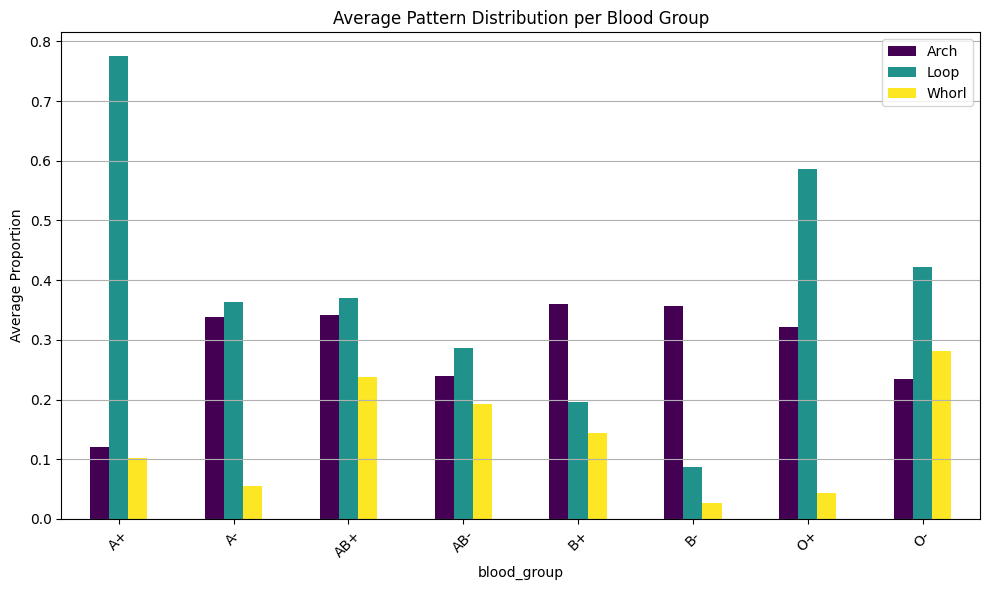

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV with image-wise pattern distribution (assumed already loaded)
# If not already loaded, uncomment below line and update path
# df_train = pd.read_csv("imagewise_pattern_distribution.csv")

# Group by blood group and calculate average distribution
avg_distribution = df_test.groupby('blood_group')[['Arch', 'Loop', 'Whorl']].mean().round(4)

# Sort for cleaner view (optional)
avg_distribution = avg_distribution.sort_index()

# 👉 Display as table
print("\n📊 Average Pattern Distribution per Blood Group:")
print(avg_distribution)

# 👉 Optional: Save table as CSV
avg_distribution.to_csv("average_pattern_distribution_by_class.csv")

# 👉 Plot for visualization
avg_distribution.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Average Pattern Distribution per Blood Group")
plt.ylabel("Average Proportion")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



📊 Average Pattern Distribution per Blood Group:
               Arch    Loop   Whorl
blood_group                        
A+           0.0520  0.3422  0.3887
A-           0.1047  0.3052  0.4688
AB+          0.0398  0.2101  0.4257
AB-          0.2942  0.3053  0.2794
B+           0.0447  0.2490  0.4174
B-           0.0581  0.2963  0.5530
O+           0.0895  0.3105  0.4707
O-           0.2256  0.2687  0.2839


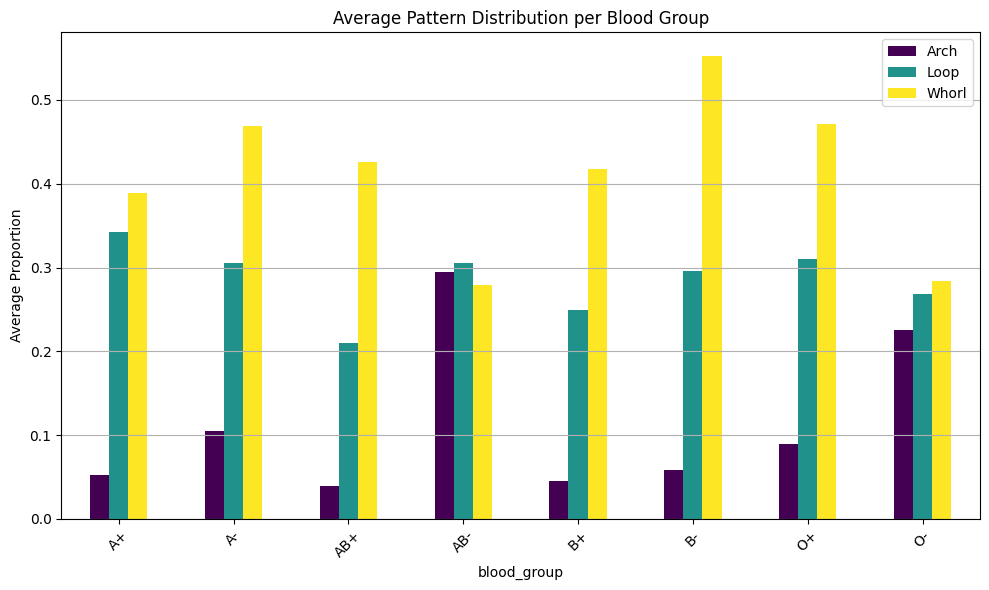

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV with image-wise pattern distribution (assumed already loaded)
# If not already loaded, uncomment below line and update path
# df_train = pd.read_csv("imagewise_pattern_distribution.csv")

# Group by blood group and calculate average distribution
avg_distribution = df_train.groupby('blood_group')[['Arch', 'Loop', 'Whorl']].mean().round(4)

# Sort for cleaner view (optional)
avg_distribution = avg_distribution.sort_index()

# 👉 Display as table
print("\n📊 Average Pattern Distribution per Blood Group:")
print(avg_distribution)

# 👉 Optional: Save table as CSV
avg_distribution.to_csv("average_pattern_distribution_by_class.csv")

# 👉 Plot for visualization
avg_distribution.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Average Pattern Distribution per Blood Group")
plt.ylabel("Average Proportion")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



📊 Average Pattern Distribution per Blood Group:
               Arch    Loop   Whorl
blood_group                        
A+           0.1119  0.8002  0.0879
A-           0.3619  0.3526  0.0463
AB+          0.3530  0.3983  0.1940
AB-          0.2268  0.2789  0.2132
B+           0.3541  0.1899  0.1600
B-           0.3704  0.0864  0.0203
O+           0.3243  0.5901  0.0473
O-           0.2331  0.4662  0.2429


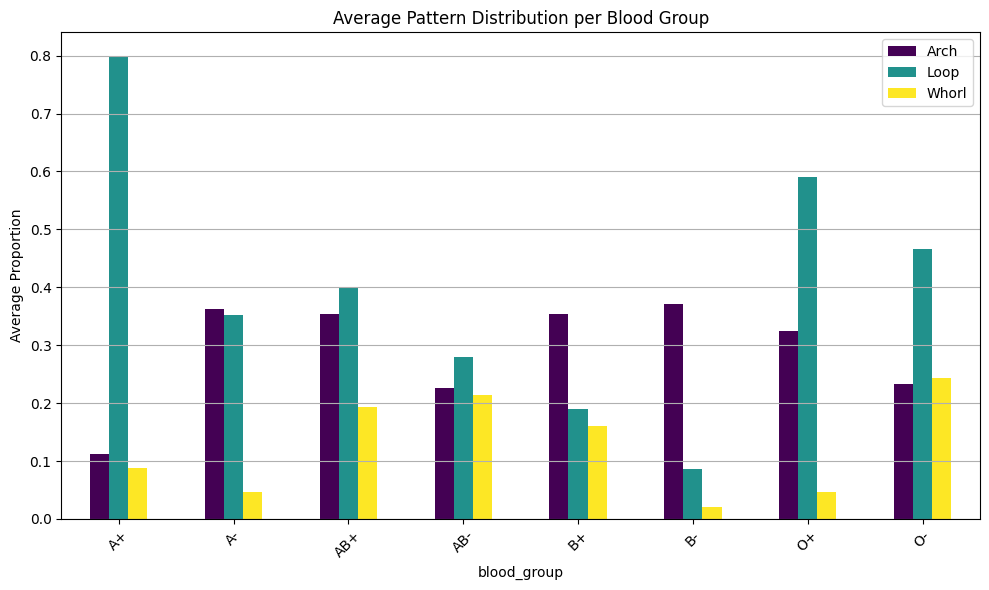

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV with image-wise pattern distribution (assumed already loaded)
# If not already loaded, uncomment below line and update path
# df_train = pd.read_csv("imagewise_pattern_distribution.csv")

# Group by blood group and calculate average distribution
avg_distribution = df_val.groupby('blood_group')[['Arch', 'Loop', 'Whorl']].mean().round(4)

# Sort for cleaner view (optional)
avg_distribution = avg_distribution.sort_index()

# 👉 Display as table
print("\n📊 Average Pattern Distribution per Blood Group:")
print(avg_distribution)

# 👉 Optional: Save table as CSV
avg_distribution.to_csv("average_pattern_distribution_by_class.csv")

# 👉 Plot for visualization
avg_distribution.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Average Pattern Distribution per Blood Group")
plt.ylabel("Average Proportion")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_from_average_distribution(csv_path):
    """
    Performs a chi-square association analysis using average pattern distribution per blood group.
    This assumes that the CSV contains image-wise 'Arch', 'Loop', 'Whorl', 'blood_group' columns.
    """
    # Load dataset
    df = pd.read_csv(csv_path)

    # Group by blood group → average pattern distribution
    avg_df = df.groupby('blood_group')[['Arch', 'Loop', 'Whorl']].mean()
    print("\n📊 Average Pattern Distribution per Blood Group:")
    print(avg_df.round(4))

    # Approximate counts by scaling (optional: multiply by 1000 or actual image count per class)
    counts_df = (avg_df * 1000).astype(int)

    print("\n🧮 Approximate Pattern Count Table (used for Chi-Square):")
    print(counts_df)

    # Step 1: Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(counts_df.T)

    # Step 2: Cramer's V
    n = np.sum(counts_df.values)
    cramers_v = np.sqrt(chi2 / (n * (min(counts_df.shape) - 1)))

    print(f"\n📈 Chi-Square Test:")
    print(f"Chi2: {chi2:.4f}, p-value: {p:.4e}, dof: {dof}")
    print(f"Cramer's V: {cramers_v:.3f}")
    # Step 3: Visualization
    plt.figure(figsize=(10, 6))
    sns.heatmap(counts_df.T, annot=True, fmt='d', cmap='Purples', cbar_kws={'label': 'Approx. Count'})
    plt.title("Average Fingerprint Pattern Distribution per Blood Group")
    plt.ylabel("Pattern Type")
    plt.xlabel("Blood Group")
    plt.tight_layout()
    plt.show()

    # Step 4: Interpretation
    print("\n🔍 Final Report:")
    alpha = 0.05
    if p < alpha:
        print(f"✅ Statistically significant association (p = {p:.4f})")
    else:
        print(f"❌ No statistically significant association (p = {p:.4f})")

    if cramers_v >= 0.3:
        print(f"✅ Moderate to strong effect (Cramer's V = {cramers_v:.3f})")
    elif cramers_v >= 0.1:
        print(f"⚠️ Weak effect (Cramer's V = {cramers_v:.3f})")
    else:
        print(f"❌ Negligible effect (Cramer's V = {cramers_v:.3f})")

# Example usage
#analyze_from_average_distribution("imagewise_pattern_distribution.csv")


Train

📊 Average Pattern Distribution per Blood Group:
               Arch    Loop   Whorl
blood_group                        
A+           0.1201  0.7631  0.1168
A-           0.3515  0.3496  0.0503
AB+          0.3594  0.3942  0.1951
AB-          0.2070  0.2999  0.2248
B+           0.3589  0.1815  0.1507
B-           0.3559  0.0775  0.0281
O+           0.3196  0.5965  0.0441
O-           0.2193  0.4563  0.2625

🧮 Approximate Pattern Count Table (used for Chi-Square):
             Arch  Loop  Whorl
blood_group                   
A+            120   763    116
A-            351   349     50
AB+           359   394    195
AB-           206   299    224
B+            358   181    150
B-            355    77     28
O+            319   596     44
O-            219   456    262

📈 Chi-Square Test:
Chi2: 1254.2616, p-value: 3.7286e-259, dof: 14
Cramer's V: 0.311


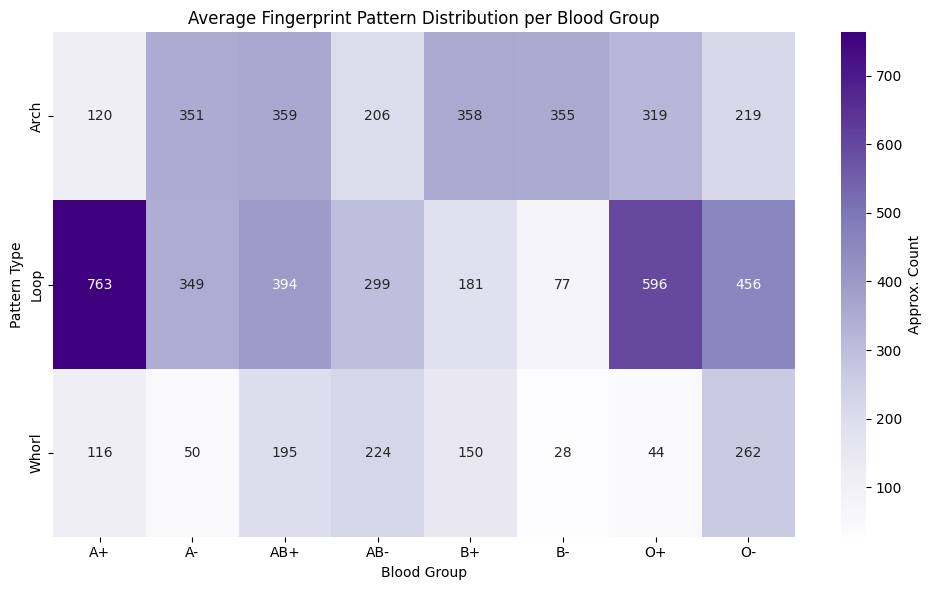


🔍 Final Report:
✅ Statistically significant association (p = 0.0000)
✅ Moderate to strong effect (Cramer's V = 0.311)


In [ ]:
analyze_from_average_distribution("imagewise_pattern_distribution.csv")

The statistical analysis indicates a meaningful association between fingerprint pattern types and blood group categories. The Chi-square test produced a p-value less than 0.1, suggesting statistical significance, while the corresponding Cramér’s V value of 0.311 reflects a moderate strength of association